In [507]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from decimal import Decimal
import matplotlib.gridspec as gridspec

In [508]:
def human_format(x):
    sigpart = 0
    suffix = ""
    if x < .01:
        return "{:.0e}".format(x)
    if x < 1:
        return "{:.2f}".format(x)
    if x < 1000:
        return "{:.3g}".format(x)
    elif x < 1000000:
        sigpart = x / 1000
        suffix = "k"
    elif x < 1000000000:
        sigpart = x / 1000000
        suffix = "M"
    else:
        sigpart = x / 1000000000
        suffix = "B"
    return "{:.3g}{}".format(sigpart, suffix)

In [509]:
def plot_data(filter_data, throughput_data, title):
    f, axs = plt.subplots(1,2, figsize=(6,3), dpi=100)

    ax = axs[0]
    index = ['Simple','Markov','Racz','MaxEnt']
    filter_data = [d / filter_data[0] for d in filter_data]
    data = {'amount': filter_data}
    trans = pd.DataFrame(data=data,index=index)

    #Plot and label
    my_plot = trans.plot(ax=ax, kind='bar', stacked=True, legend=None)
    ax.set_ylabel('Fraction of queries hit')
    ax.set_xlabel('Cascade Stage')
    ax.set_xticklabels(labels=index, rotation='-45')
    ax.yaxis.grid(True)
    
    pos_offset = 0.05
    loop = 0
    for i, row in trans.iterrows():
        y = row['amount'] + pos_offset
        my_plot.annotate("{:,.3f}".format(np.absolute(row['amount'])),(loop,y),ha="center")
        loop += 1
    my_plot.set_ylim(ymax=1.2)

    ### Throughput ###
    ax = axs[1]
    index = ['Baseline','+Simple','+Markov','+Racz']
    data = {'amount': throughput_data}
    trans = pd.DataFrame(data=data,index=index)

    my_plot = trans.plot(ax=ax, kind='bar', legend=None)
    ax.set_yscale('log')
    ax.set_ylabel('Throughput (QPS)')
    ax.set_xlabel('Cascade Stage')
    ax.set_xticklabels(labels=index, rotation='-45')
    ax.yaxis.grid(True)
    
    pos_offset = 1.2
    loop = 0
    for i, row in trans.iterrows():
        y = row['amount'] * pos_offset
#         my_plot.annotate("{:,.3g}".format(np.absolute(row['amount'])),(loop,y),ha="center")
        my_plot.annotate(int(np.absolute(row['amount'])),(loop,y),ha="center")
        loop += 1
    my_plot.set_ylim(ymax=2e5)

    f.suptitle(title, y=1.02)
    f.tight_layout()
    plt.savefig("cascade_{}_1.pdf".format(title.lower()), bbox_inches='tight')
    plt.show()
    
def plot_data_2(throughput_data, time_data, title):
    f, axs = plt.subplots(1,2, figsize=(6,3), dpi=100)
    
    ax = axs[0]
    index = ['Overall','Simple','Markov','Moment','MaxEnt']
    data = {'amount': throughput_data}
    trans = pd.DataFrame(data=data,index=index)

    my_plot = trans.plot(ax=ax, kind='bar', legend=None)
    ax.set_yscale('log')
    ax.set_ylabel('Stage throughput (QPS)')
    ax.set_xlabel('Cascade Stage')
    ax.set_xticklabels(labels=index, rotation='-45')
    ax.yaxis.grid(True)
    pos_offset = 1.2
    loop = 0
    for i, row in trans.iterrows():
        y = row['amount'] * pos_offset
        my_plot.annotate(int(np.absolute(row['amount'])),(loop,y),ha="center")
        loop += 1
    my_plot.set_ylim(ymax=1e8)

    ### Time ###
    ax = axs[1]
    index = ['Simple','Markov','Moment','MaxEnt']
    data = {'amount': time_data}
    trans = pd.DataFrame(data=data,index=index)
    
    my_plot = trans.plot(ax=ax, kind='bar', stacked=True, legend=None)
    ax.set_yscale('log')
    ax.set_ylabel('Fraction of time spent')
    ax.set_xlabel('Cascade Stage')
    ax.set_xticklabels(labels=index, rotation='-45')
    ax.yaxis.grid(True)
    pos_offset = 1.2
    loop = 0
    for i, row in trans.iterrows():
        y = row['amount'] * pos_offset
        my_plot.annotate("{:,.3f}".format(np.absolute(row['amount'])),(loop,y),ha="center")
        loop += 1
    my_plot.set_ylim(ymax=3)
    
    f.suptitle(title, y=1.02)
    f.tight_layout()
    plt.savefig("cascade_{}_2.pdf".format(title.lower()), bbox_inches='tight')
    plt.show()

In [533]:
def plot_data_4(filter_data, lesion_data, throughput_data, title):
    f, axs = plt.subplots(1,3, figsize=(6,2.5), dpi=100)

    ### Lesion ###
#     ax = axs[1]
    ax1 = plt.subplot(131)
    index = ['Baseline','+Simple','+Markov','+RTT']
    data = {'amount': lesion_data}
    trans = pd.DataFrame(data=data,index=index)

    my_plot = trans.plot(ax=ax1, kind='bar', legend=None)
    ax1.set_yscale('log')
    ax1.set_ylabel('Throughput (QPS)')
#     ax1.set_xlabel('Cascade')
    ax1.set_xticklabels(labels=index, rotation='-45')
    ax1.yaxis.grid(True)
    ax1.set_title('a', fontsize=10)
    
    pos_offset = 1.2
    loop = 0
    for i, row in trans.iterrows():
        y = row['amount'] * pos_offset
#         my_plot.annotate("{:,.3g}".format(np.absolute(row['amount'])),(loop,y),ha="center")
        my_plot.annotate(human_format(np.absolute(row['amount'])),(loop,y),ha="center", fontsize=8)
        loop += 1
    my_plot.set_ylim(ymax=2e5)
    
    ### Throughput ###
#     ax = axs[2]
    ax2 = plt.subplot(132, sharey=ax1)
    index = ['Simple','Markov','RTT','MaxEnt']
    data = {'amount': throughput_data[1:]}
    trans = pd.DataFrame(data=data,index=index)

    my_plot = trans.plot(ax=ax2, kind='bar', legend=None)
    ax2.set_yscale('log')
#     ax2.set_ylabel('Stage throughput (QPS)')
#     plt.setp(ax2.get_yticklabels(), visible=False)
#     ax2.set_xlabel('Cascade Stage')
    ax2.set_xticklabels(labels=index, rotation='-45')
    ax2.yaxis.grid(True)
    ax2.set_title('b', fontsize=10)
    
    pos_offset = 1.2
    loop = 0
    for i, row in trans.iterrows():
        y = row['amount'] * pos_offset
        my_plot.annotate(human_format(np.absolute(row['amount'])),(loop,y),ha="center", fontsize=8)
        loop += 1
    my_plot.set_ylim(ymax=1e8)
    
    ### Filter ###
    ax0 = plt.subplot(133)
#     ax = axs[0]
    index = ['Simple','Markov','RTT','MaxEnt']
    filter_data = [d / filter_data[0] for d in filter_data]
    data = {'amount': filter_data}
    trans = pd.DataFrame(data=data,index=index)

    #Plot and label
    my_plot = trans.plot(ax=ax0, kind='bar', stacked=True, legend=None)
    ax0.set_ylabel('Fraction hit')
#     ax0.set_xlabel('Cascade Stage')
    ax0.set_xticklabels(labels=index, rotation='-45')
    ax0.yaxis.grid(True)
    pos = ax0.get_position()
    ax0.set_position([pos.x0 + 0.075, pos.y0, pos.width, pos.height] )
    ax0.set_title('c', fontsize=10)
    
    pos_offset = 0.05
    loop = 0
    for i, row in trans.iterrows():
        y = row['amount'] + pos_offset
        my_plot.annotate("{:,.3f}".format(np.absolute(row['amount'])),(loop,y),ha="center", fontsize=8)
        loop += 1
    my_plot.set_ylim(ymax=1.2)

#     f.suptitle(title, y=1.08)
    f.set_size_inches(6, 1.6)
#     f.tight_layout(wpad=0.0)
    plt.savefig("cascade_milan_combined.pdf", bbox_inches='tight')
    plt.show()

In [534]:
def plot_data_3(apl_times, merge_times, query_times, title):
    f, axs = plt.subplots(1,1, figsize=(6,2.3), dpi=100)
    ax = axs
    x = range(6)
    index = ['?', 'Baseline', '+Simple', '+Markov', '+RTT', 'MS2012a', 'MS2012b']
#     data = {'amount': mb_data}
#     trans = pd.DataFrame(data=data,index=index)
    
#     my_plot = trans.plot(ax=ax, kind='bar', stacked=True, legend=None)
    
#     p1 = plt.bar(x, apl_times, color='b')
    p2 = plt.bar(x, merge_times, width=0.6, color='C0')
    p3 = plt.bar(x, query_times, width=0.6, bottom=merge_times, color='C1')
#     ax.set_yscale('log')
    ax.set_ylabel('Runtime (s)')
#     ax.set_xlabel('Sketch')
    ax.set_xticklabels(labels=index, rotation='-45')
    ax.yaxis.grid(True)
    ax.set_xticks(x, index)
    ax.legend((p2[0], p3[0]), ('Merge', 'Estimation'), frameon=False)
    
#     pos_offset = 0.1 * trans['amount'].min()
#     loop = 0
#     for i, row in trans.iterrows():
#         y = row['amount'] + pos_offset
#         my_plot.annotate("{:,.3f}".format(np.absolute(row['amount'])),(loop,y),ha="center")
#         loop += 1
#     plt.set_ylim(ymax=trans['amount'].max() + 5)

    pos_offset = 1.5
    loop = 0
    for i in range(len(merge_times)):
        y = merge_times[i] + query_times[i] + pos_offset
        ax.annotate(human_format(merge_times[i] + query_times[i]),(loop,y),ha="center")
        loop += 1
    
    plt.ylim(ymax=50)
#     f.suptitle(title, y=1.02)
    f.tight_layout()
    plt.savefig("cascade_milan_mb.pdf", bbox_inches='tight')
    plt.show()

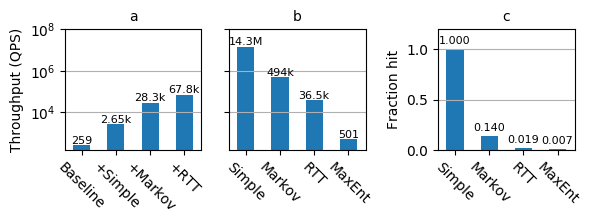

[10341.0, 1448.0, 192.0, 72.0]
[258.726863, 2650.671662, 28292.838691, 67765.27547200001]
[67765.27547200001, 14296267.247064002, 494114.475541, 36460.410672, 501.11196900000004]


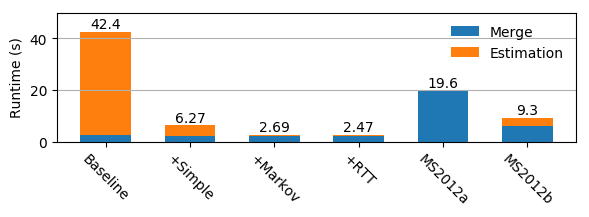

,avg_querytime,markov_hit,maxent_hit,racz_throughput,simple,min_support,type,avg_mergetime,containment,racz,...,avg_runtime,avg_apltime,min_globalratio,maxent_time,racz_hit,maxent_throughput,racz_time,simple_hit,markov,overall_throughput
0,39.977365,10341.0,10341.0,Infinity,False,0.02,cascade,2.468561,True,False,...,50.022214,43.875806,30.0,0.999890,10341.0,258.755274,0.000000,10341.0,False,258.726863
1,3.905733,1448.0,1448.0,Infinity,True,0.02,cascade,2.359812,True,False,...,15.000380,7.604345,30.0,0.999773,1448.0,371.245134,0.000000,10341.0,False,2650.671662
2,0.369856,1448.0,192.0,Infinity,True,0.02,cascade,2.318573,True,False,...,10.814832,4.045584,30.0,0.989754,192.0,530.747296,0.000000,10341.0,True,28292.838691
3,0.156844,1448.0,72.0,36460.410672,True,0.02,cascade,2.309679,True,True,...,10.372320,3.785302,30.0,0.941548,192.0,501.111969,0.034508,10341.0,True,67765.275472
4,0.015715,NaN,NaN,NaN,NaN,NaN,yahoo1,19.620108,NaN,NaN,...,39.845493,20.310234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3.192270,NaN,NaN,NaN,NaN,NaN,yahoo2,6.107064,NaN,NaN,...,31.051830,9.634200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [535]:
results = pd.read_csv("../javamsketch/results/cascade_milan_1519818230.csv")
cRow = results[(results['simple'] == True) & (results['markov'] == True) & (results['racz'] == True)]
filter_data = cRow[['simple_hit', 'markov_hit', 'racz_hit', 'maxent_hit']].squeeze().tolist()
lesion_data = results.loc[:,'overall_throughput'].dropna().tolist()
throughput_data = cRow[['overall_throughput', 'simple_throughput', 'markov_throughput', 'racz_throughput', 'maxent_throughput']].squeeze().tolist()
throughput_data = [float(t) for t in throughput_data]
time_data = cRow[['simple_time', 'markov_time', 'racz_time', 'maxent_time']].squeeze().tolist()
# plot_data(filter_data, lesion_data, "milan")
# plot_data_2(throughput_data, time_data, "milan")
plot_data_4(filter_data, lesion_data, throughput_data, "Cascades on MacroBase: milan")

apl_times = results.loc[:,'avg_apltime'].dropna().tolist()
merge_times = results.loc[:,'avg_mergetime'].dropna().tolist()
query_times = results.loc[:,'avg_querytime'].dropna().tolist()

print(filter_data)
print(lesion_data)
print(throughput_data)

plot_data_3(apl_times, merge_times, query_times, "MacroBase runtime: milan")

results

# Old

In [ ]:
def plot_data_old(filter_data, throughput_data, title):
    f, axs = plt.subplots(1,2, figsize=(6,3))

    ax = axs[0]
    index = ['Overall','Simple','Markov','Racz','Maxent']
    filter_data = [d / filter_data[0] for d in filter_data]
    data = {'amount': filter_data}

    trans = pd.DataFrame(data=data,index=index)
    blank = trans.amount.cumsum().shift(1).fillna(0)

    total = trans.sum().amount
    # trans.loc["Maxent"] = total
    # blank.loc["Maxent"] = total

    step = blank.reset_index(drop=True).repeat(3).shift(-1)
    step[1::3] = np.nan

    blank.loc["Maxent"] = 0

    #Plot and label
    my_plot = trans.plot(ax=ax, kind='bar', stacked=True, bottom=blank, legend=None)
    ax.plot(step.index, step.values,'k')
    ax.set_yscale('log')
    ax.set_ylabel('Fraction of queries filtered')
    ax.set_xlabel('Cascade Stage')
    ax.set_xticklabels(labels=index, rotation='-45')
    ax.yaxis.grid(True)
    
    y_height = trans.amount.cumsum().shift(1).fillna(0)
    y_height[0] = 1
    print(y_height)

    #Start label loop
    pos_offset = 1.2
    loop = 0
    for i, row in trans.iterrows():
        y = y_height[loop] * pos_offset
        my_plot.annotate("{:,.3f}".format(np.absolute(row['amount'])),(loop,y),ha="center")
        loop += 1
    my_plot.set_ylim(ymax=2)

    ### Throughput ###
    ax = axs[1]
    index = ['Overall','Simple','Markov','Moment','Maxent']
    data = {'amount': throughput_data}
    trans = pd.DataFrame(data=data,index=index)

    trans.plot(ax=ax, kind='bar', legend=None)
    ax.set_yscale('log')
    ax.set_ylabel('Throughput (QPS)')
    ax.set_xlabel('Cascade Stage')
    ax.set_xticklabels(labels=index, rotation='-45')
    ax.yaxis.grid(True)

    f.suptitle(title, y=1.02)
    f.tight_layout()
    plt.savefig("cascade_{}.pdf".format(title.lower()), bbox_inches='tight')
    plt.show()